In [ ]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

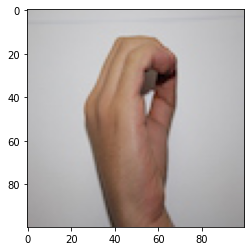

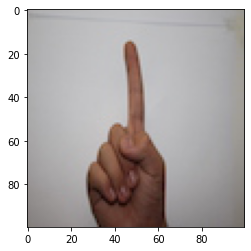

In [ ]:
labels = pd.read_csv("/content/drive/My Drive/Dataset/labels.csv", index_col=0)

labels.head()

def get_image(row_id, root="/content/drive/My Drive/Dataset/Dataset/"):
    """
    Converts an image number into the file path where the image is located,
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

# subset the dataframe to just Apis (genus is 0.0) get the value of the sixth item in the index
apis_row = labels[labels.genus == 0.0].index[2]

# show the corresponding image of an Apis
plt.imshow(get_image(apis_row))
plt.show()

# subset the dataframe to just Bombus (genus is 1.0) get the value of the sixth item in the index
bombus_row = labels[labels.genus == 1.0].index[3]

plt.imshow(get_image(bombus_row))
plt.show()

Color bombus image has shape:  [[[168 166 167]
  [172 170 171]
  [172 170 171]
  ...
  [157 154 145]
  [156 153 144]
  [155 152 143]]

 [[169 167 168]
  [168 166 167]
  [171 169 170]
  ...
  [155 154 149]
  [154 153 148]
  [153 152 147]]

 [[162 160 161]
  [155 153 154]
  [158 158 158]
  ...
  [159 154 148]
  [157 152 146]
  [157 152 146]]

 ...

 [[132 128 125]
  [134 130 127]
  [136 132 131]
  ...
  [122 117 111]
  [120 115 109]
  [119 114 108]]

 [[132 127 124]
  [134 129 126]
  [135 130 127]
  ...
  [119 114 108]
  [118 113 107]
  [117 112 106]]

 [[130 125 122]
  [132 127 124]
  [134 129 126]
  ...
  [118 113 107]
  [117 112 106]
  [116 111 105]]]
Greyscale bombus image has shape:  [[0.6529298  0.66861608 0.66861608 ... 0.60387686 0.59995529 0.59603373]
 [0.65685137 0.6529298  0.66469451 ... 0.60334118 0.59941961 0.59549804]
 [0.62940039 0.60194941 0.61960784 ... 0.60639176 0.59854863 0.59854863]
 ...
 [0.50444588 0.51228902 0.52069765 ... 0.46129373 0.45345059 0.44952902]
 [0.501

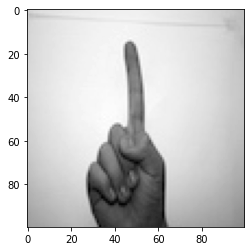

In [ ]:
bombus = get_image(bombus_row)

print('Color bombus image has shape: ', bombus)

# convert the bombus image to greyscale
grey_bombus = rgb2grey(bombus)

plt.imshow(grey_bombus, cmap=mpl.cm.gray)

print('Greyscale bombus image has shape: ', grey_bombus)

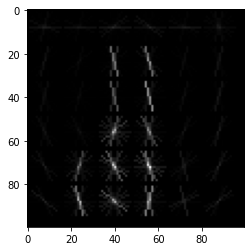

In [ ]:
hog_features, hog_image = hog(grey_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

plt.imshow(hog_image, cmap=mpl.cm.gray)

In [ ]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

bombus_features = create_features(bombus)

print(bombus_features)

[168 166 167 ... 116 111 105]


In [ ]:
def create_feature_matrix(label_dataframe):
    features_list = []

    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(bombus_features)

    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)


In [ ]:
print('Feature matrix shape is: ', feature_matrix.shape)
print(feature_matrix)

Feature matrix shape is:  (10, 30000)
[[168 166 167 ... 116 111 105]
 [168 166 167 ... 116 111 105]
 [168 166 167 ... 116 111 105]
 ...
 [168 166 167 ... 116 111 105]
 [168 166 167 ... 116 111 105]
 [168 166 167 ... 116 111 105]]


In [ ]:
# define standard scaler
ss = StandardScaler()


In [ ]:
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)
pca = PCA(n_components=10)
# use fit_transform to run PCA on our standardized matrix
bees_pca = ss.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)


PCA matrix shape is:  (10, 30000)


In [ ]:
#X = pd.DataFrame(bees_pca)
X = pd.DataFrame(feature_matrix)
y = pd.Series(labels.genus.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()
X_train.shape
print(X_train)

   0      1      2      3      4      ...  29995  29996  29997  29998  29999
0    168    166    167    172    170  ...    112    106    116    111    105
1    168    166    167    172    170  ...    112    106    116    111    105
7    168    166    167    172    170  ...    112    106    116    111    105
2    168    166    167    172    170  ...    112    106    116    111    105
8    168    166    167    172    170  ...    112    106    116    111    105
6    168    166    167    172    170  ...    112    106    116    111    105
5    168    166    167    172    170  ...    112    106    116    111    105

[7 rows x 30000 columns]


In [ ]:
svm = SVC(C=0.1,kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.3333333333333333


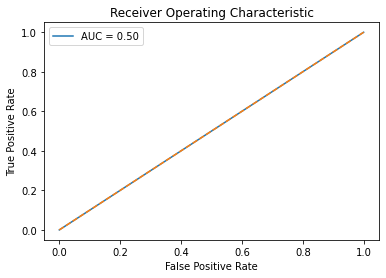

In [ ]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

In [ ]:
print(y_test)

4    0
9    1
3    0
dtype: int64


In [ ]:
print(y_pred)

[1 1 1]
